This project is an exploration of recommendation engine methods applied to two public datasets from Kaggle:<br>
- the [book recommendation dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset): content-based and collaborative filtering (see the book-recommender notebook),
- **the [the groceries dataset](https://www.kaggle.com/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba): association rules-based recommendations.**

## 0. Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy
from sklearn.cluster import KMeans
from scipy.sparse import coo_matrix
from numpy.linalg import norm

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
grocs = pd.read_csv('Groceries data.csv')
grocs.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [4]:
grocs.rename(columns = {'itemDescription': 'Item', 'Member_number': 'Member', 'day_of_week': 'dow'}, inplace = True)

In [5]:
grocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Member  38765 non-null  int64 
 1   Date    38765 non-null  object
 2   Item    38765 non-null  object
 3   year    38765 non-null  int64 
 4   month   38765 non-null  int64 
 5   day     38765 non-null  int64 
 6   dow     38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


## 1. EDA

#### 1.1. Items purchased

In [6]:
items_cnt = grocs.groupby('Item')['Date'].count().reset_index()
items_cnt.rename(columns = {'Date': 'Orders'}, inplace = True)
items_cnt.head()

,Item,Orders
0,Instant food products,60
1,UHT-milk,323
2,abrasive cleaner,22
3,artif. sweetener,29
4,baby cosmetics,3


In [7]:
print(f"The dataset contains {grocs['Item'].nunique()} unique items.")

The dataset contains 167 unique items.


In [8]:
items_cnt.sort_values('Orders', ascending = True, inplace = True)
items_cnt.head()

,Item,Orders
114,preservation products,1
79,kitchen utensil,1
4,baby cosmetics,3
5,bags,4
57,frozen chicken,5


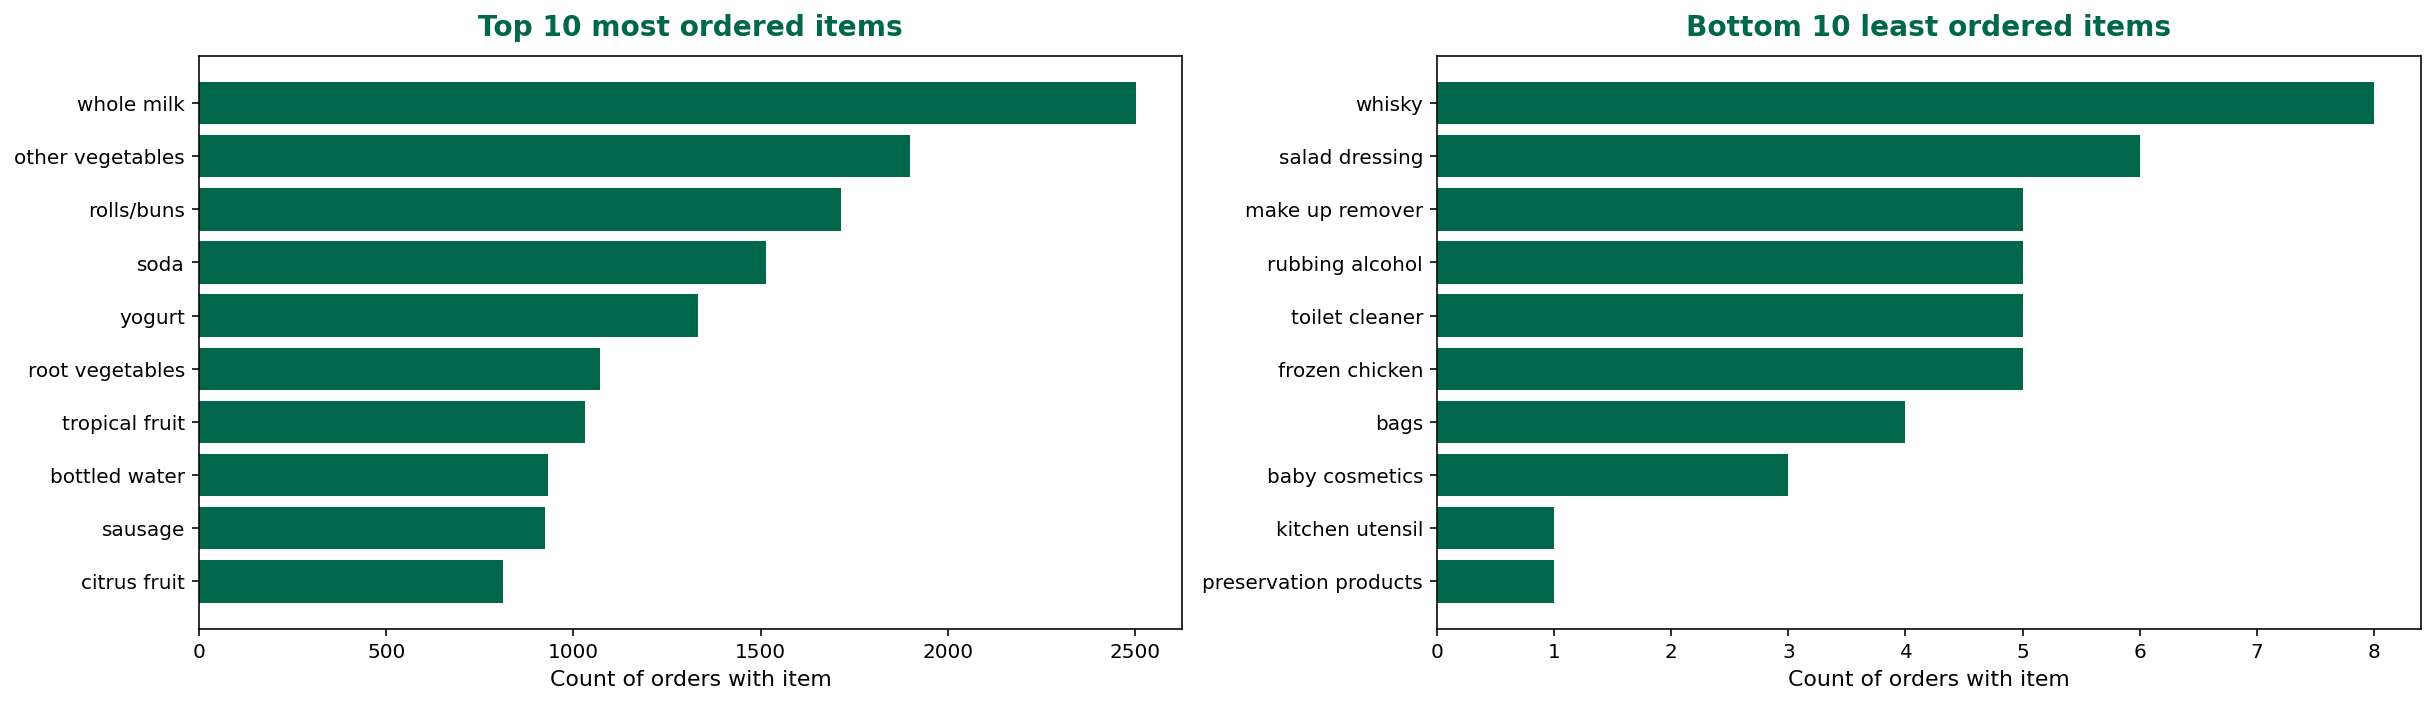

In [9]:
plt.figure(figsize = (17, 5))
plt.subplot(1,2,1)
plt.barh(list(items_cnt['Item'])[-10:], list(items_cnt['Orders'])[-10:], color = '#00674b')
plt.title('Top 10 most ordered items', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#00674b'}, pad = 10)
#plt.xticks(rotation = 90)
plt.xlabel('Count of orders with item', fontdict= {'fontsize': 11})
plt.subplot(1,2,2)
plt.barh(list(items_cnt['Item'])[:10], list(items_cnt['Orders'])[:10], color = '#00674b')
plt.title('Bottom 10 least ordered items', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#00674b'}, pad = 10)
#plt.xticks(rotation = 90)
plt.xlabel('Count of orders with item', fontdict= {'fontsize': 11})
plt.tight_layout();

In [10]:
items_cnt.sort_values('Orders', ascending = False, inplace = True)
items_cnt['cum_orders'] = items_cnt['Orders'].cumsum()/items_cnt['Orders'].sum()
items_cnt.head()

,Item,Orders,cum_orders
164,whole milk,2502,0.064543
102,other vegetables,1898,0.113504
122,rolls/buns,1716,0.157771
138,soda,1514,0.196827
165,yogurt,1334,0.231240


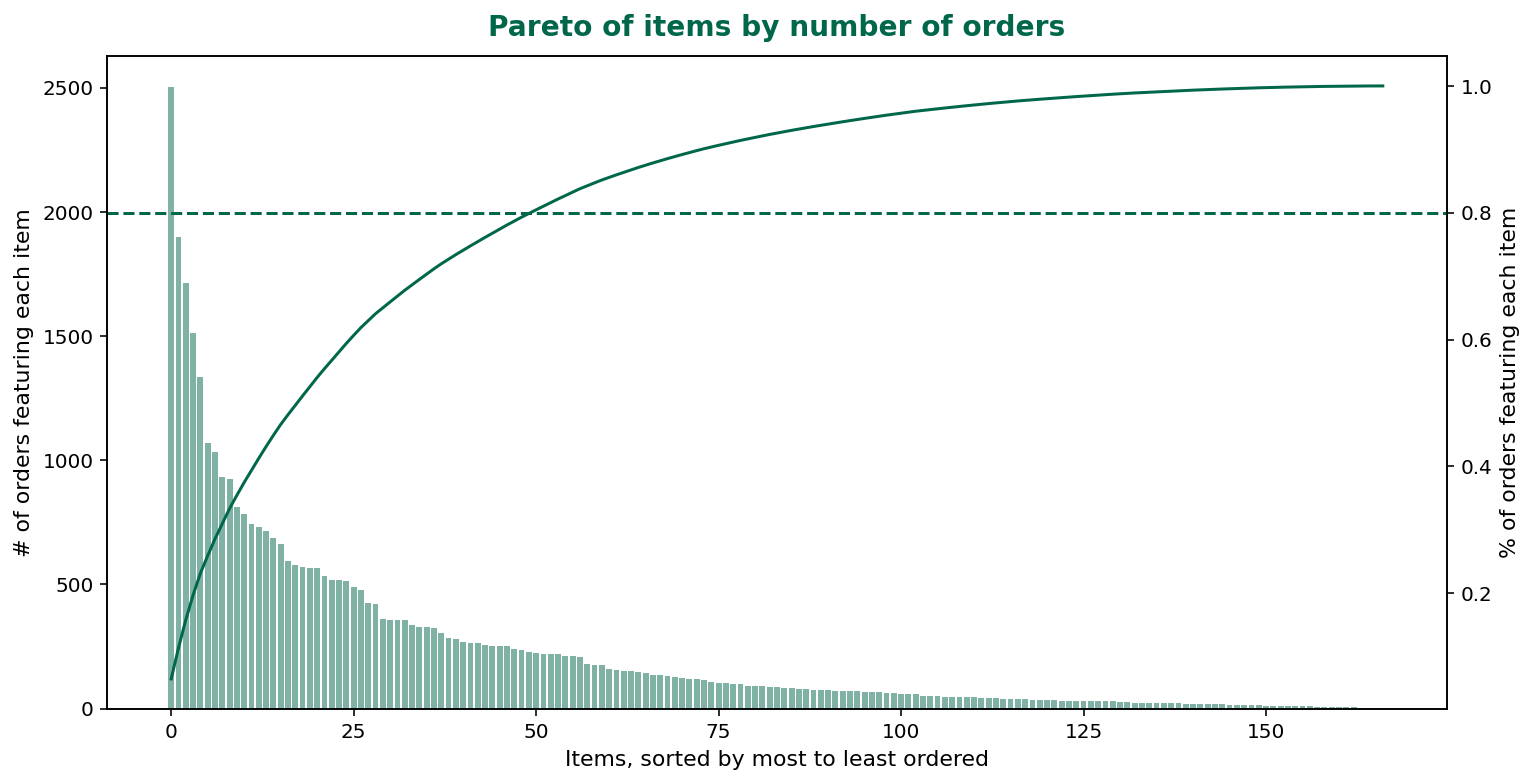

In [11]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

ax1.bar(range(len(items_cnt)), items_cnt['Orders'], color = '#00674b', alpha = 0.5)
plt.ylabel('# of orders featuring each item', fontdict = {'fontsize': 11})
plt.xlabel('Items, sorted by most to least ordered', fontdict = {'fontsize': 11})
ax2 = ax1.twinx()
ax2.plot(range(len(items_cnt)), items_cnt['cum_orders'], color = '#00674b')
plt.title('Pareto of items by number of orders', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#00674b'}, pad = 10)
plt.ylabel('% of orders featuring each item', fontdict = {'fontsize': 11});
ax2.axhline(0.8, ls = '--', color = '#00674b');

plt.savefig('item_order_pareto.png', pad_inches = 0.2)

Of ~200 unique items in the dataset, only about 50 were included in more than 80% of orders.

### 1.2. Patterns over time

In [12]:
grocs['Date'] = pd.to_datetime(grocs['Date'])

what_when = grocs.groupby('Date')['Member'].count().reset_index()
what_when.rename(columns = {'Member': 'Orders'}, inplace = True)

what_when.set_index('Date', inplace = True)

In [13]:
what_when.index.nunique()

728

In [14]:
what_when.index.max() - what_when.index.min()

Timedelta('728 days 00:00:00')

The summary `what_when` lists 728 dates which is the number of days between 2014-01-01 to 2015-12-30: all days in this period are represented.

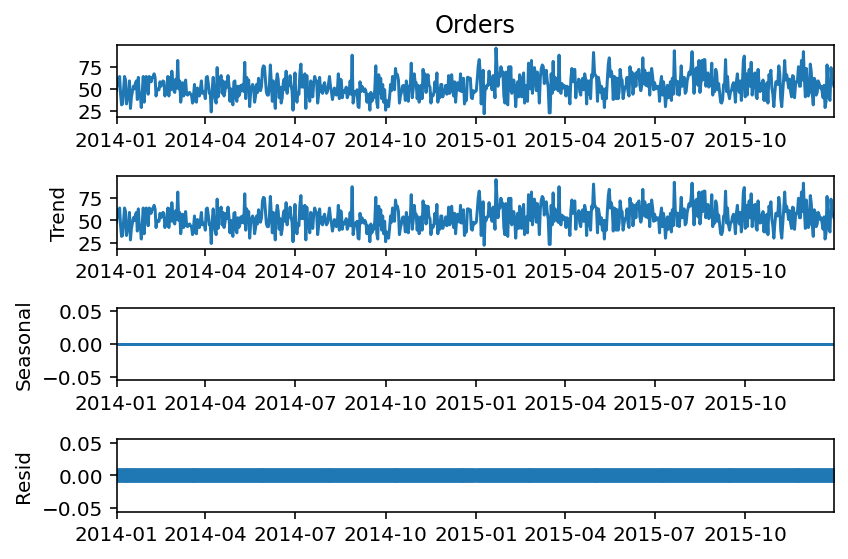

In [15]:
# Decomposing the time series into trend, seasonal, and residual components.
trends = seasonal_decompose(what_when['Orders'], period = 1)#, model = 'multiplicative')

# Plot the decomposed time series.
#plt.figure(figsize = (20,20))
trends.plot();

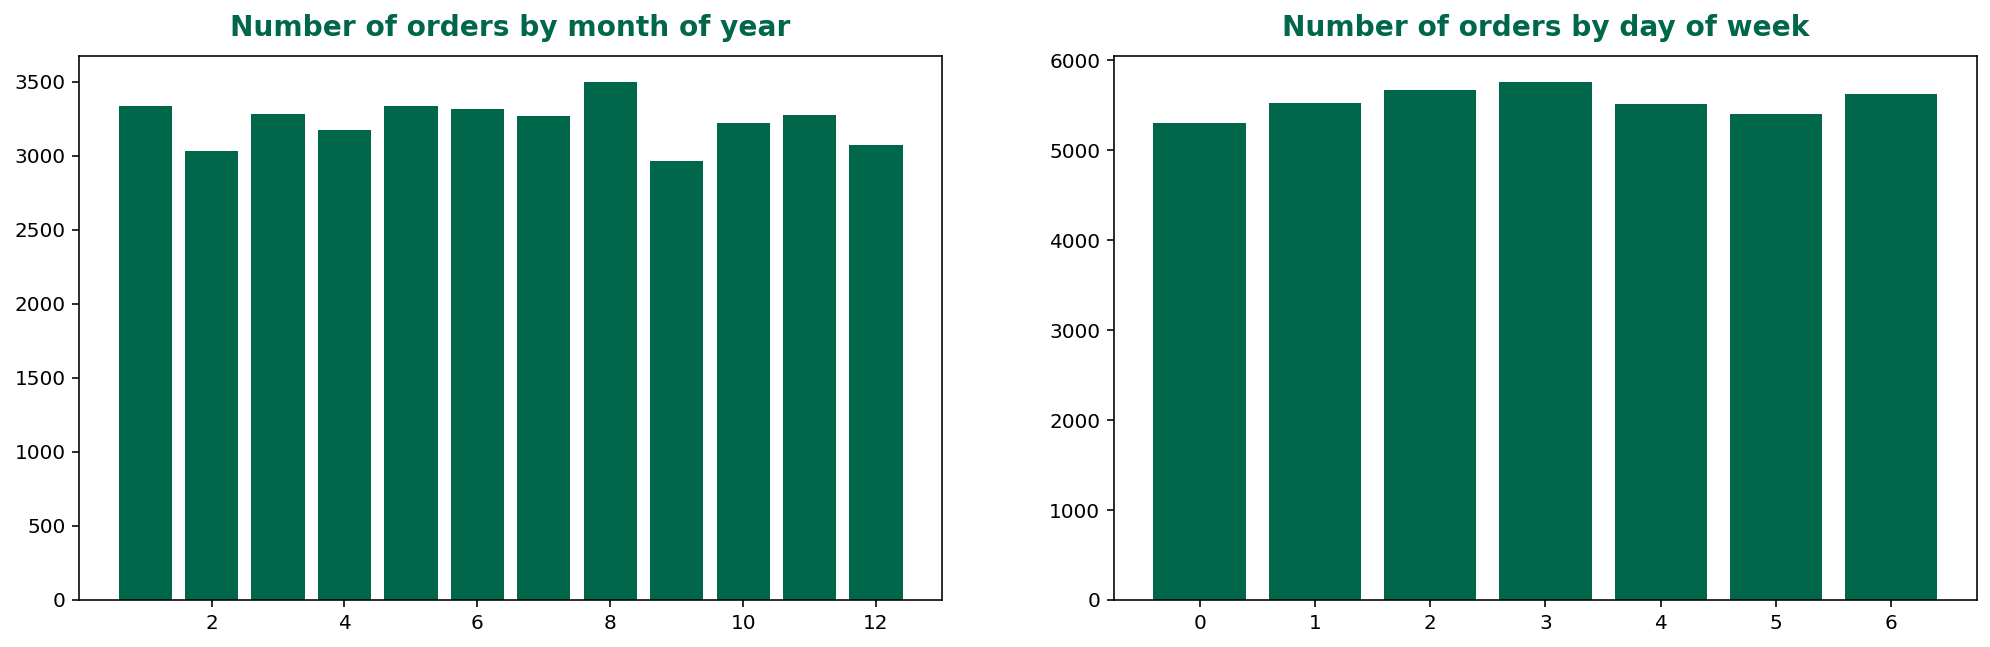

In [16]:
orders_by_dow = grocs.groupby('dow')['Member'].count().reset_index()
orders_by_mth = grocs.groupby('month')['Member'].count().reset_index()

plt.figure(figsize = (17,5))
plt.subplot(1,2,1)
plt.bar(orders_by_mth['month'], orders_by_mth['Member'], color = '#00674b')
plt.title('Number of orders by month of year', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#00674b'}, pad = 10);
plt.subplot(1,2,2)
plt.bar(orders_by_dow['dow'], orders_by_dow['Member'], color = '#00674b')
plt.title('Number of orders by day of week', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#00674b'}, pad = 10);

### 2. Extracting Apriori Association Rules based on basket data

#### 2.1. **Step 1**: finding items occuring in at least 5% of all transactions:

In [17]:
freq_items = list(items_cnt[items_cnt['cum_orders']<=0.95]['Item'])
len(freq_items)

96

#### 2.2. **Step 2**: finding all pairs of items in transactions with items from step 1 and eliminating those which occur less than 10% of the time:

Because the dataset does not include a unique transaction identifier, I assume below that every item ordered by a given member on a given day represents one transaction:

In [18]:
grocs['Txn'] = grocs.apply(lambda x: str(x.Member) + str(x.Date), axis = 1)

In [19]:
grocs.head()

,Member,Date,Item,year,month,day,dow,Txn
0,1808,2015-07-21,tropical fruit,2015,7,21,1,18082015-07-21 00:00:00
1,2552,2015-05-01,whole milk,2015,5,1,4,25522015-05-01 00:00:00
2,2300,2015-09-19,pip fruit,2015,9,19,5,23002015-09-19 00:00:00
3,1187,2015-12-12,other vegetables,2015,12,12,5,11872015-12-12 00:00:00
4,3037,2015-01-02,whole milk,2015,1,2,4,30372015-01-02 00:00:00


In [20]:
baskets = grocs.pivot_table(index = 'Txn', columns= 'Item', values = 'year', aggfunc='count', fill_value=0)

In [21]:
baskets.head()

Item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Txn,,,,,,,,,,,,,,,,,,,,,
10002014-06-24 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10002015-03-15 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
10002015-05-27 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002015-07-24 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002015-11-25 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
freq_items = baskets[baskets.apply(lambda x: x[baskets.columns].sum()/baskets.shape[0]>=0.01, axis = 1) ==1].columns

In [23]:
len(freq_items)

167

In [24]:
def find_freq_pairs(dataset, min_freq):
    freq_items = list(dataset[dataset.apply(lambda x: x[dataset.columns].sum()/dataset.shape[0]>=min_freq, axis = 1) ==1].columns)
    freq_pairs = []
    for item1 in freq_items:
        freq_items.remove(item1)
        for item2 in freq_items:
            frequency = dataset[(dataset[item1]==1) & (dataset[item2]==1)].shape[0]/dataset.shape[0]
            if frequency>= min_freq:
                freq_pairs.append((item1, item2))
    print(f'There are {len(freq_pairs)} pairs of items that were bought together in more than {min_freq*100}% of transactions.')
    return freq_pairs

In [25]:
freq_pairs = find_freq_pairs(baskets, 0.01)

There are 4 pairs of items that were bought together in more than 1.0% of transactions.


In [26]:
freq_pairs 

[('other vegetables', 'whole milk'),
 ('rolls/buns', 'whole milk'),
 ('soda', 'whole milk'),
 ('whole milk', 'yogurt')]

#### 2.3. **Step 3**: finding meaningful rules for all pairs from step 2:

In [27]:
def find_pair_rules(dataset, pairs, min_freq):
    rules = []
    for pair in pairs:
        a, b = pair
        if dataset[(dataset[a]==1) & (dataset[b]==1)].shape[0]/ dataset[dataset[a]==1].shape[0] > min_freq:
            rules.append(a+" --> "+b)
        if baskets[(dataset[a]==1) & (dataset[b]==1)].shape[0]/ dataset[dataset[b]==1].shape[0] > min_freq:
            rules.append(b+" --> "+a)
    print(f"{len(rules)} rules found for the {len(pairs)} pairs of frequently bought together items.")
    return rules

In [28]:
pair_rules = find_pair_rules(baskets, freq_pairs, 0.1)

4 rules found for the 4 pairs of frequently bought together items.


In [29]:
pair_rules

['other vegetables --> whole milk',
 'rolls/buns --> whole milk',
 'soda --> whole milk',
 'yogurt --> whole milk']

#### 2.4. **Step 4**: finding items occuring in at least x% of all transactions

In [30]:
def find_three_item_sets(pairs, dataset, min_freq):
    threes = []
    for pair in pairs:
        a,b = pair
        items = list(dataset.columns)
        for c in items:
            if c == a or c == b:
                pass
            elif dataset[(dataset[a]==1) & (dataset[b]==1) & (dataset[c]==1)].shape[0]/dataset.shape[0] > min_freq:
                threes.append((a,b,c))
        print(f"There are {len(threes)} sets of three items that were bought together in more than {min_freq*100}% of all transactions.")
        return threes

It appears as though no three items have meaningful support, so to run through the final step, I assume 0.1% support is sufficient:

In [31]:
tis = find_three_item_sets(freq_pairs, baskets, 0.001)

There are 1 sets of three items that were bought together in more than 0.1% of all transactions.


In [32]:
tis

[('other vegetables', 'whole milk', 'soda')]

#### 2.5. **Step 5**: finding meaningful rules for three-item sets from step 4:

In [33]:
def find_tis_rules(dataset, three_item_sets, min_freq):
    rules = []
    for ti_set in three_item_sets:
        a, b,c = ti_set
        if dataset[(dataset[a]==1) & (dataset[b]==1) & (dataset[c]==1)].shape[0]/dataset[(dataset[a]==1) & (dataset[b]==1)].shape[0] > min_freq:
            rules.append(a+" + "+b+" --> "+c)
        if dataset[(dataset[a]==1) & (dataset[b]==1) & (dataset[c]==1)].shape[0]/dataset[dataset[c]==1].shape[0] > min_freq:
            rules.append(c+" --> "+a+" + "+b)
    print(f"{len(rules)} rules found for the {len(three_item_sets)} sets of frequently bought together items.")
    return rules

In [34]:
find_tis_rules(baskets, tis, 0.05)

1 rules found for the 1 sets of frequently bought together items.


['other vegetables + whole milk --> soda']